# Introduction

In this tutorial, we will learn how to implement different policies and temporal difference learning algorithms, as well as a hybrid (model building) algorithm, then compare their performance to the dynamic programming algorithms we implemented in the first tutorial.

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Tutorial

## Learning algorithms and policies

__Learning algorithms__:

*Sarsa (on-policy)*

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

with temporal discount rate $\gamma$ and learning rate $\alpha$.

*Q-learning (off-policy)*

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}


__Policies__:

*Epsilon-greedy*

\begin{align}
P(a_t|s_t) = \epsilon \frac{1}{N_a}  + (1-\epsilon)1[a_t =\max_\limits{a}Q(a_t,s_t)]
\end{align}

*Softmax*

\begin{align}
P(a_t|s_t) = \frac{\exp(Q(a_t,s_t)/\tau)}{\Sigma_{i=1}^n \exp(Q(i)/\tau)}
\end{align}

Please familiarize yourself with the code below, as it will help your write your own code to solve the exercises.

In [2]:
# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [3]:
def init_state(params):
    """
    Initialize the state at the beginning of an episode.
    Args:
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the initial state.
    """
    if params['environment'].name == 'windy_cliff_grid':
        return 0
    elif params['environment'].name == 'n_armed_bandit':
        return 0
    elif params['environment'].name == 'cheese_world':
        return 0
    elif params['environment'].name == 'cliff_world':
        return 0
    elif params['environment'].name == 'quentins_world':
        return 54

def update_state(state, action, params):
    """
    State transition based on world, action and current state.
    Args:
        state: integer corresponding to the current state.
        action: integer corresponding to the action taken.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the next state;
        an integer corresponding to the reward received.
    """
    next_state, reward = params['environment'].get_outcome(state, action)
    return next_state, reward
    
def call_policy(state, value, params):
    """
    Call a policy to choose actions, given current state and value function.
    Args:
        state: integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding action chosen according to the policy.
    """
    # multiple options for policy
    if params['policy'] == 'epsilon_greedy':
        return epsilon_greedy(state, value, params)
    elif params['policy'] == 'softmax':
        return softmax(state, value, params)
    else: # random policy (if policy not recognized, choose randomly)
        return randint(params['environment'].n_actions)

def update_value(prev_state, action, reward, state, value, params):
    """
    Update the value function.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state;
          should be None if the episode ended.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    if params['learning_rule'] == 'q_learning':
        # off policy learning
        return q_learning(prev_state, action, reward, state, value, params)
    elif params['learning_rule'] == 'sarsa':
        # on policy learning
        return sarsa(prev_state, action, reward, state, value, params)
    else:
        print('Learning rule not recognized')

def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.6  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 0.5  # temporal discount factor
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

## Exercise 1: Decision Policies

1. Write an epsilon-greedy policy function.

2. Write a softmax policy function.

Tip: Both functions should take the current state, the value function and default parameters as input and return an action.

In [4]:
def epsilon_greedy(state, value, params):
    """
    Epsilon-greedy policy: selects the maximum value action with probabilty
      (1-epsilon) and selects randomly with epsilon probability.
    Args:
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        action: an integer corresponding action chosen according to the policy.
    """
    value_now = value[state,:]
    if rand() > params['epsilon']:
        action = where(value_now == max(value_now))[0][0]
    else:
        # We deal with ties by selecting randomly.
        action = randint(len(value_now)) 
    return action

def softmax(state, value, params):
    """
    Softmax policy: selects action probabilistically depending on the value.
    Args:
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the action chosen according to the policy.
    """
    value_now = value[state,:]
    prob = exp(value_now * params['beta'])  # beta is the inverse temperature
    prob = prob / sum(prob)  # normalize
    cum_prob = cumsum(prob)  # cummulation summation
    action = where(cum_prob > rand())[0][0]
    return action

## Exercise 2: Learning Algorithms

1. Write a Q-learning (off-policy) algorithm.
2. Modify your Q-learning algorithm to obtain a Sarsa (on-policy) algorithm.

Tip: Both functions should take the previous state, action taken, reward received, value function, current state and default parameters and return the updated value function.

In [5]:
def q_learning(prev_state, action, reward, state, value, params):
    """
    Q-learning: updates the value function and returns it.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer corresponding to the action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    # maximum value at current state
    if state == None:
        max_value = 0
    else:
        max_value = max(value[state,:])
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value

def sarsa(prev_state, action, reward, state, value, params):
    """
    Sarsa: updates the value function and returns it.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    # select the expected value at current state based on our
    # policy by sampling from it
    if state == None:
        policy_value = 0
    else:
        # sample action from the policy for the next state
        policy_action = call_policy(state, value, params)
        # get the value based on the action sampled from the policy
        policy_value = value[state, policy_action]
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * policy_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value

## Exercise 3

1. Write code that allows you to select a world, a learning algorithm and a decision policy. Run 500 episodes (visits to the world) with learning across episodes. Make sure to set a maximum number of steps per episode (e.g. 1000). Use the functions provided in the plot_util module to:
    - Plot the value associated with each action at each state;
    - Plot the action corresponding to the maximum value at each state;
    - Plot the maximum value in each state;
    - Plot the total reward obtained in each episode.
2. Experiment with different values for the parameters:
    - Pick a range for the learning rate $\alpha$ and look at how the results change.
    - Pick a range for the inverse temperature $\beta$ (using a softmax policy) and look at how the results change.
    - Pick a range for $\epsilon$ (using an $\epsilon$-greedy policy) and look at how the results change.
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
3. Explore the cliff world with an $\epsilon$-greedy policy (try $\epsilon$=0.1) comparing the performance of Q-learning (off-policy) and Sarsa (on-policy). What differences do you notice? What do these differences tell us about on- and off-policy learning?

To make sure that your algorithms have been implemented correctly, compare your results to the ones shown below.

Cliff world using Q-learning and an $\epsilon$-greedy policy with $\epsilon$=0.1 and $\alpha$=0.3:

<img src="fig/tutorial1_ex3_qlearning_values.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex3_qlearning_actions.png",height="300",width="300">
<img src="fig/tutorial1_ex3_qlearning_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex3_qlearning_rewards.png",height="300",width="300">

Quentin's world using Sarsa and a softmax policy with $\beta$=10 and $\alpha$=0.4:

<img src="fig/tutorial1_ex3_sarsa_values.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex3_sarsa_actions.png",height="300",width="300">
<img src="fig/tutorial1_ex3_sarsa_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex3_sarsa_rewards.png",height="300",width="300">

In [6]:
def run_learning(value, params, n_episodes, max_steps):
    """
    Args:
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
        n_episodes: integer, number of episodes to run.
        max_steps: integer, maximum number of steps to take in each episode.
    Returns:
        a dictionary where the keys are integers (episode numbers)
          and the values are integers (total rewards per episode);
        the updated value function (matrix indexed by state and action).
    """
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in xrange(n_episodes):
    
        state = init_state(params)  # initialize state    
        step = 0
        reward_sum = 0

        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            value = update_value(state, action, reward, next_state, value, params)  # update value function
            state = next_state
            reward_sum += reward  # sum rewards obtained
            step += 1
            if next_state == None:
                break  # episode ends

        reward_sums[episode] = reward_sum

    return reward_sums, value

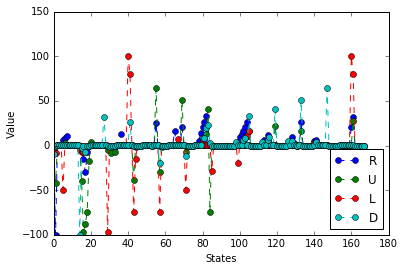

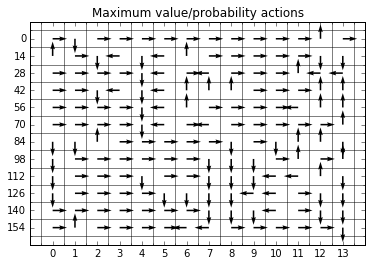

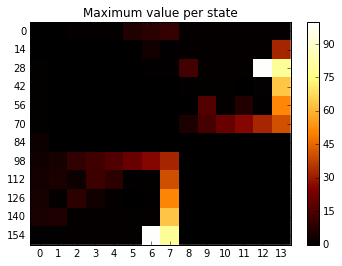

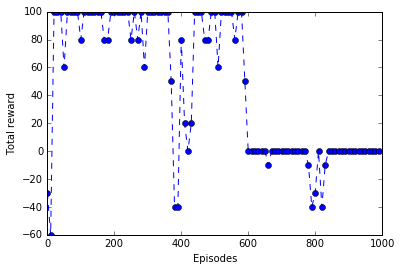

In [7]:
# Choose a world
# env = worlds.n_armed_bandit()
# env = worlds.cheese_world()
# env = worlds.cliff_world()
# env = worlds.quentins_world()
env = worlds.windy_cliff_grid()

# Default parameters
params = default_params(environment=env)

# Decision-maker
# Choose a policy, a learning rule and parameter values
params['learning_rule'] = 'sarsa'
params['policy'] = 'epsilon_greedy'
params['epsilon'] = 0.01
params['alpha'] = 0.5
params['beta'] = 10
params['gamma'] = 0.8

# Episodes/trials
n_episodes = 1000
max_steps = 1000

# Initialization
# Start with uniform value function
value = np.ones((env.n_states, env.n_actions))

# Run learning
reward_sums, value = run_learning(value, params, n_episodes, max_steps)

fig = plot_state_action_values(env, value)
fig = plot_quiver_max_action(env, value)
fig = plot_heatmap_max_val(env, value)
fig = plot_rewards(n_episodes, reward_sums, average_range=10)

## Exercise 4: Dyna-Q

1. Implement the Dyna-Q algorithm for a deterministic environment.

Tip: The function should take the default parameters, an integer k for the number random updates, and a threshold for the stopping criterium as input and return a value function and deterministic model of the environment.

In [8]:
def dyna_q(value, T, R, params, k=100, n_iter=1000):
    """
    Dyna-Q algorithm.
    Args:
        params: a dictionary containing the default parameters.
        k: int, number of random updates per iteration.
        n_iter: int, number of iterations.
    Returns:
        the value function (matrix indexed by state and action);
        the transition matrix (matrix indexed by state and action);
        the reward matrix (matrix indexed by state and action).
        
    """    
    env = params['environment']
    observed_pairs = []
    
    # Randomly sample an initial state
    state = np.random.randint(env.n_states)
    
    for _ in xrange(n_iter):
        
        # Select an action according to the current value function 
        action = call_policy(state, value, params)
        
        # Add state-action pair to the list of observed pairs
        observed_pairs.append((state, action))
        
        # Obtain next state and reward
        next_state, reward = update_state(state, action, params)

        # Value of previous state-action pair
        prev_value = value[state, action]

        # Maximum value at the new state
        if next_state == None:
            max_value = 0
        else:
            max_value = max(value[next_state,:])

        # Reward prediction error
        delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor
        
        # Update the value function
        value[state, action] = prev_value + params['alpha'] * delta  # alpha is the learning rate
            
        # Update the model
        T[state,action] = next_it_state = next_state
        R[state,action] = reward

        # Perform k additional updates at random
        for _ in xrange(k):
            # Randomly sample a state-action pair
            state, action = observed_pairs[np.random.randint(len(observed_pairs))]

            # Obtain next state and reward according to the current model
            next_state = T[state, action] if np.isfinite(T[state, action]) else None
            reward = R[state, action]

            # Value of previous state-action pair
            prev_value = value[state, action]

            # Maximum value at the new state
            if next_state == None:
                max_value = 0
            else:
                max_value = max(value[int(next_state),:])

            # Reward prediction error
            delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor

            # Update the value function
            value[state, action] = prev_value + params['alpha'] * delta  # alpha is the learning rate

        # Update the state for the next iteration
        # If next state is None, we've reached the end of the MDP, so start over from random state
        if next_it_state == None:
            state = np.random.randint(env.n_states)
        else:
            state = next_it_state

    return value, T, R

## Exercise 5

1. Write code that allows you to test the performance of Dyna-Q for a selected world and a selected learning rule. Run 500 episodes (visits to the world) with learning across episodes. Make sure to set a maximum number of steps per episode (e.g. 1000). Use the functions provided in the plot_util module to:
    - Plot the value associated with each action at each state;
    - Plot the action corresponding to the maximum value at each state;
    - Plot the maximum value in each state;
    - Plot the total reward obtained in each episode.
2. Experiment with different values for the parameters:
    - Pick a range for the learning rate $\alpha$ and look at how the results change.
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
    - Pick a range for k (number of random updates performed in Dyna-Q) and look at how the results change.
3. Compare these results with those obtained for TD learning in the previous tutorial, as well as the dynamic programming algorithms from this tutorial.

To make sure that your algorithm has been implemented correctly, compare your results to the ones shown below.

Windy cliff grid using Dyna-Q and an $\epsilon$-greedy policy with $\epsilon$=0.05, $\alpha$=0.5 and $\gamma$=0.8:

<img src="fig/tutorial2_ex5_dynaq_values.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex5_dynaq_actions.png",height="300",width="300">
<img src="fig/tutorial2_ex5_dynaq_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex5_dynaq_rewards.png",height="300",width="300">


In [9]:
def run_dyna_q(value, params, n_episodes, max_steps):
    """
    Args:
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
        n_episodes: integer, number of episodes to run.
        max_steps: integer, maximum number of steps to take in each episode.
    Returns:
        a dictionary where the keys are integers (episode numbers)
          and the values are integers (total rewards per episode); 
        the updated value function (matrix indexed by state and action).
    """
    reward_sums = np.zeros(n_episodes)

    T = np.zeros((env.n_states, env.n_actions))
    R = np.zeros((env.n_states, env.n_actions))
    
    # Loop over episodes
    for episode in xrange(n_episodes):
    
        state = init_state(params)  # initialize state    
        step = 0
        reward_sum = 0
        
        value, T, R = dyna_q(value, T, R, params)
        
        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            
            reward_sum += reward  # sum rewards obtained
            if next_state is None:
                break  # episode ends
            state = next_state
            step += 1
    
        reward_sums[episode] = reward_sum

    return reward_sums, value

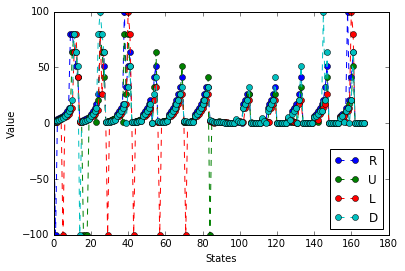

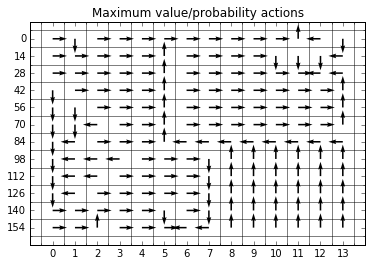

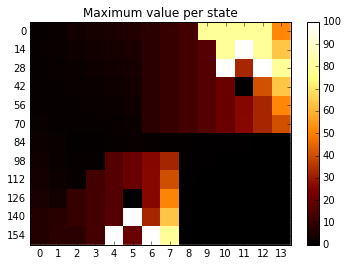

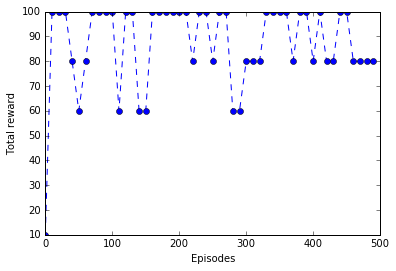

In [10]:
# Choose a world
# env = worlds.cliff_world()
# env = worlds.quentins_world()
env = worlds.windy_cliff_grid()

# Default parameters
params = default_params(environment=env)

# Decision-maker
# Choose a policy and parameter values
params['policy'] = 'epsilon_greedy'
params['epsilon'] = 0.05
params['alpha'] = 0.5
params['gamma'] = 0.8
params['beta'] = 3

# Episodes/trials
n_episodes = 500
max_steps = 1000

# Initialization
# Start with uniform value function
value = np.ones((env.n_states, env.n_actions))

# Run learning
reward_sums, value = run_dyna_q(value, params, n_episodes, max_steps)

fig = plot_state_action_values(env, value)
fig = plot_quiver_max_action(env, value)
fig = plot_heatmap_max_val(env, value)
fig = plot_rewards(n_episodes, reward_sums, average_range=10)

## Exercise 6 (Optional) 
1. We will now compare Q-learning and Dyna-Q to see how each of these algorithms responds to a change in the structure of the environment. We will use a modified version of the windy cliff grid, windy_cliff_grid_2, which is the same as the original except for the location of the doors leading to the two windy rooms.

    - For each algorithm, run 500 episodes in the original world. Then, switch to the modified world and run 500 more episodes.
    - You can use an $\epsilon$-greedy policy with $\epsilon$=0.05 throughout.
    - After both sets of episodes, plot the value of each action at each state, the action of maximum value at each state, the maximum value at each state and the total reward obtained in each episode (plot the accumulated rewards only for the 500 episodes in the modified world).
    - What do you notice about the difference in each algorithm's performance once the environment has changed?

In [15]:
def update_value(prev_state, action, reward, state, value, params):
    """
    Update the value function.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state;
          should be None if the episode ended.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    if params['learning_rule'] == 'q_learning':
        # off policy learning
        return q_learning(prev_state, action, reward, state, value, params)
    elif params['learning_rule'] == 'sarsa':
        # on policy learning
        return sarsa(prev_state, action, reward, state, value, params)
    else:
        print('Learning rule not recognized')

def q_learning(prev_state, action, reward, state, value, params):
    """
    Q-learning: updates the value function and returns it.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer corresponding to the action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    # maximum value at current state
    if state == None:
        max_value = 0
    else:
        max_value = max(value[state,:])
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value

def run_learning(value, params, n_episodes, max_steps):
    """
    Args:
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
        n_episodes: integer, number of episodes to run.
        max_steps: integer, maximum number of steps to take in each episode.
    Returns:
        a dictionary where the keys are integers (episode numbers)
          and the values are integers (total rewards per episode);
        the updated value function (matrix indexed by state and action).
    """
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in xrange(n_episodes):
    
        state = init_state(params)  # initialize state    
        step = 0
        reward_sum = 0

        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            value = update_value(state, action, reward, next_state, value, params)  # update value function
            state = next_state
            reward_sum += reward  # sum rewards obtained
            step += 1
            if next_state == None:
                break  # episode ends

        reward_sums[episode] = reward_sum

    return reward_sums, value

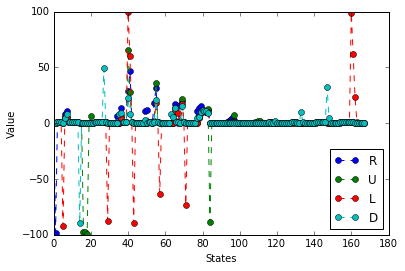

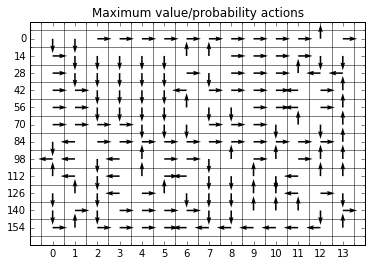

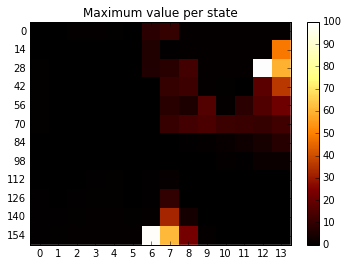

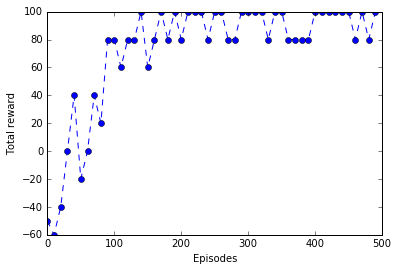

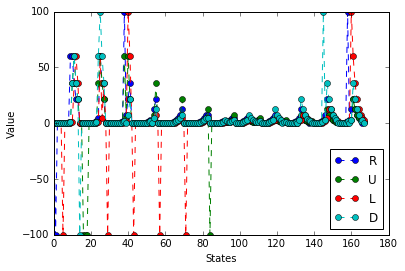

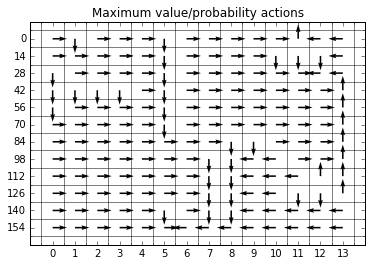

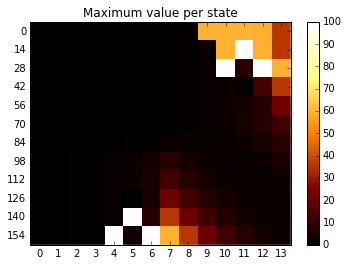

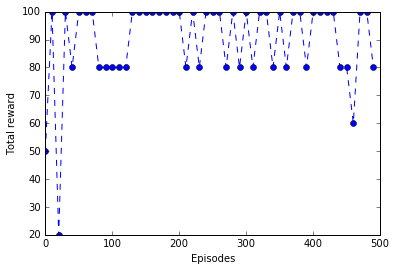

In [16]:
env = worlds.windy_cliff_grid()

# Default parameters
params = default_params(environment=env)

# Decision-maker
params['learning_rule'] = 'q_learning'
params['policy'] = 'epsilon_greedy'
params['epsilon'] = 0.05
params['alpha'] = 0.5
params['gamma'] = 0.8

# Episodes/trials
n_episodes = 500
max_steps = 1000

# Initialization
# Start with uniform value functions
value_q = np.ones((env.n_states, env.n_actions))
value_dyna = np.ones((env.n_states, env.n_actions))

# Run Q-learning
reward_sums, value_q = run_learning(value_q, params, n_episodes, max_steps)

# Run Dyna-Q
reward_sums, value_dyna = run_dyna_q(value_dyna, params, n_episodes, max_steps)

# Change the environment.
env = worlds.windy_cliff_grid_2()
params = default_params(environment=env)

# Run Q-learning
reward_sums, value_q = run_learning(value_q, params, n_episodes, max_steps)

fig = plot_state_action_values(env, value_q)
fig = plot_quiver_max_action(env, value_q)
fig = plot_heatmap_max_val(env, value_q)
fig = plot_rewards(n_episodes, reward_sums, average_range=10)

# Run Dyna-Q
reward_sums, value_dyna = run_dyna_q(value_dyna, params, n_episodes, max_steps)

fig = plot_state_action_values(env, value_dyna)
fig = plot_quiver_max_action(env, value_dyna)
fig = plot_heatmap_max_val(env, value_dyna)
fig = plot_rewards(n_episodes, reward_sums, average_range=10)
